In [1]:
import numpy as np
import torch
from torch import nn
from matplotlib import pyplot as plta
import os
os.environ['VXM_BACKEND'] = 'pytorch'
from voxelmorph import networks
import voxelmorph as vxm
from tqdm.notebook import trange
from tqdm.notebook import tqdm
import nibabel as nib
import imageio
from matplotlib import pyplot as plt
import pathlib
from torch.utils.data import DataLoader,Dataset

In [2]:
segPath = pathlib.Path('/data01/junyi/datasets/HCP_20')/'seg'
WGMsegPath = sorted([*pathlib.Path('/data01/junyi/datasets/HCP_20/segmentations/').iterdir()])

In [3]:
for subid,WGMseg in enumerate(WGMsegPath):
    path= next(WGMseg.glob('*'))
    os.system(f'cp {path} {segPath}/WGC{subid :03d}.nii.gz')

In [4]:
f'{segPath}/WGC{subid :03d}.nii.gz'


'/data01/junyi/datasets/HCP_20/seg/WGC019.nii.gz'

In [5]:
def torch_binom(n, k):
    mask = n.detach() >= k.detach()
    n = mask * n
    k = mask * k
    a = torch.lgamma(n + 1) - torch.lgamma((n - k) + 1) - torch.lgamma(k + 1)
    return torch.exp(a) * mask

In [6]:
M = torch.rand((100000,3,3))+torch.eye(3)

In [ ]:
T = torch.eye(3)- M.mT @ M
a = M @ (torch_binom(torch.tensor(range(30)),torch.tensor(-1/2)).reshape(1,-1,1,1)*torch.stack([(-1)**i*torch.matrix_power(T,i) for i in range(30)],1)).sum(1)

In [ ]:
U,S,Vh = torch.linalg.svd(M)


In [ ]:
torch_binom(torch.tensor(range(10)),torch.tensor(-1/2)).unsqueeze(1).shape

torch.Size([10, 1])

In [ ]:
torch.cat([torch.matrix_power(torch.rand((3,3)),i) for i in range(10)]).shape

torch.Size([30, 3])

In [ ]:
# os.system(f'tckgen -algorithm FACT /data01/junyi/datasets/HCP_100/100307/T1w/Diffusion/tractseg_output/TOM_new/FX.nii.gz FX.tck -minlength 40 -maxlength 250 -select 2000  -nthreads 24 -seed_image /data01/junyi/datasets/HCP_100/100307/T1w/Diffusion/tractseg_output/bundle_segmentations/FX_right.nii.gz -force')


In [ ]:
#scp junyi@zfl01:/data01/junyi/datasets/HCP_100/100307/T1w/Diffusion/FA_MNI.nii.gz ~/Desktop

In [ ]:
img_data_dir = '/data01/junyi/datasets/HCP_100'
dir_list = sorted(list(pathlib.Path(img_data_dir).iterdir()))[:20]

In [ ]:
# for name in (dire.name for dire in dir_list):
#     tgt_path = pathlib.Path('/data01/junyi/datasets/HCP_20/')
#     src_path = pathlib.Path(f'/data02/SWM-HCP-S1200/segmentations/{name}.tar.gz')
#     if src_path.exists():
#         command = f'tar xzf /data02/SWM-HCP-S1200/segmentations/{name}.tar.gz -C {tgt_path} --wildcards --no-anchored *GMWMCSF*' 
#         print(command)
#         os.system(command)

tar xzf /data02/SWM-HCP-S1200/segmentations/100307.tar.gz -C /data01/junyi/datasets/HCP_20 --wildcards --no-anchored *GMWMCSF*
tar xzf /data02/SWM-HCP-S1200/segmentations/100408.tar.gz -C /data01/junyi/datasets/HCP_20 --wildcards --no-anchored *GMWMCSF*
tar xzf /data02/SWM-HCP-S1200/segmentations/101107.tar.gz -C /data01/junyi/datasets/HCP_20 --wildcards --no-anchored *GMWMCSF*
tar xzf /data02/SWM-HCP-S1200/segmentations/101309.tar.gz -C /data01/junyi/datasets/HCP_20 --wildcards --no-anchored *GMWMCSF*
tar xzf /data02/SWM-HCP-S1200/segmentations/101915.tar.gz -C /data01/junyi/datasets/HCP_20 --wildcards --no-anchored *GMWMCSF*
tar xzf /data02/SWM-HCP-S1200/segmentations/103111.tar.gz -C /data01/junyi/datasets/HCP_20 --wildcards --no-anchored *GMWMCSF*
tar xzf /data02/SWM-HCP-S1200/segmentations/103414.tar.gz -C /data01/junyi/datasets/HCP_20 --wildcards --no-anchored *GMWMCSF*
tar xzf /data02/SWM-HCP-S1200/segmentations/103818.tar.gz -C /data01/junyi/datasets/HCP_20 --wildcards --no-anc

In [57]:
paths = list(pathlib.Path('/data01/junyi/datasets//HCP_100').glob('**/FA*'))

In [56]:
backbone_tracts = ['AF', 'ATR', 'CA', 'CC',
                   'CG', 'CST', 'FPT', 'FX', 'ICP', 'IFO', 'ILF', 'MCP', 'MLF', 'OR', 'POPT', 'SCP',
                   ]
# backbone_tracts = ['AF', 'ATR', 'CA', 'CC',
#                    'CG', 'CST', 'FPT', 'FX', 'ICP', 'IFO', 'ILF', 'MCP', 'MLF', 'OR', 'POPT', 'SCP',]
len(backbone_tracts)

16

In [58]:
class SpatialTransformer(nn.Module):
    """
    N-D Spatial Transformer
    """

    def __init__(self, size, mode='bilinear'):
        super().__init__()

        self.mode = mode

        # create sampling grid
        vectors = [torch.arange(0, s) for s in size]
        grids = torch.meshgrid(vectors, indexing='ij')
        grid = torch.stack(grids)
        grid = torch.unsqueeze(grid, 0)
        grid = grid.type(torch.FloatTensor)

        # registering the grid as a buffer cleanly moves it to the GPU, but it also
        # adds it to the state dict. this is annoying since everything in the state dict
        # is included when saving weights to disk, so the model files are way bigger
        # than they need to be. so far, there does not appear to be an elegant solution.
        # see: https://discuss.pytorch.org/t/how-to-register-buffer-without-polluting-state-dict
        self.register_buffer('grid', grid, persistent=False)

    def forward(self, src, flow):
        # new locations
        new_locs = self.grid + flow
        shape = flow.shape[2:]

        # need to normalize grid values to [-1, 1] for resampler
        for i in range(len(shape)):
            new_locs[:, i, ...] = 2 * (new_locs[:, i, ...] / (shape[i] - 1) - 0.5)

        # move channels dim to last position
        # also not sure why, but the channels need to be reversed
        if len(shape) == 2:
            new_locs = new_locs.permute(0, 2, 3, 1)
            new_locs = new_locs[..., [1, 0]]
        elif len(shape) == 3:
            new_locs = new_locs.permute(0, 2, 3, 4, 1)
            new_locs = new_locs[..., [2, 1, 0]]

        return nn.functional.grid_sample(src, new_locs, align_corners=True, mode=self.mode)

In [59]:
src = torch.randint(0,2,(1,1,12,12,12))
flow = torch.rand((1,3,12,12,12))+2
nnST = SpatialTransformer((12,12,12),mode='bilinear')

In [ ]:
out=nnST(src.float(),flow).squeeze()
out[5],

(tensor([[0.7125, 0.8514, 0.8797, 0.2981, 0.9095, 0.9339, 0.4446, 0.1421, 0.3276,
          0.0122, 0.0000, 0.0000],
         [0.2099, 0.8732, 0.6289, 0.9264, 0.2568, 0.7447, 0.5873, 0.9199, 0.0982,
          0.4443, 0.0000, 0.0000],
         [0.5423, 0.6980, 0.4317, 0.2586, 0.1908, 0.0000, 0.8924, 0.9346, 0.8884,
          0.3615, 0.0000, 0.0000],
         [0.6792, 0.5401, 0.0158, 0.0144, 0.2055, 0.3939, 0.7966, 0.8904, 0.8270,
          0.6073, 0.0000, 0.0000],
         [0.2726, 0.7459, 0.4683, 0.6181, 0.4002, 0.5393, 0.5292, 0.6370, 0.3653,
          0.1481, 0.0000, 0.0000],
         [0.2165, 0.5895, 0.7066, 0.4593, 0.5517, 0.0866, 0.0000, 0.5419, 0.5569,
          0.4373, 0.0000, 0.0000],
         [0.3502, 0.4610, 0.8262, 0.6906, 0.3953, 0.3086, 0.2077, 0.2917, 0.4957,
          0.1108, 0.0000, 0.0000],
         [0.4580, 0.0896, 0.0250, 0.7642, 0.2444, 0.0152, 0.4079, 0.7484, 0.7275,
          0.3982, 0.0000, 0.0000],
         [0.5396, 0.0164, 0.1132, 0.0989, 0.0518, 0.0307, 0.0351

In [60]:
def crop(x,indice_down, indice_up):
    x = x.astype(np.float32)
    return x[indice_down[0]:indice_up[0],indice_down[1]:indice_up[1],indice_down[2]:indice_up[2]]
class FiberDatasetDir(Dataset):
    def __init__(self, img_data_dir: pathlib.Path, transform=None, ):

        self.img_data_dir = sorted(list(pathlib.Path(img_data_dir).iterdir()))[:2]
        self.transform = transform
        tmp = nib.load(list(self.img_data_dir[0].glob('**/FA_MNI*'))[0])
        self.config = (tmp.affine,tmp.header)
        self.shape = tmp.get_fdata().shape

    def __len__(self):
        return len(self.img_data_dir)

    def __getitem__(self, idx):
        images_dir_path = self.img_data_dir[idx]
        struct_dict = {}
        indice_down = np.array(self.shape)//2-np.array([128//2, 160//2, 128//2])
        indice_up =(np.array(self.shape)//2)+np.array([128//2, 160//2, 128//2])
        FA_path = sorted(list(images_dir_path.glob('**/FA_MNI*')))[0]
        struct_dict['FA'] = self.transform(nib.load(FA_path).get_fdata()[::-1],indice_down,indice_up)[np.newaxis, ...]
            

        for tract in backbone_tracts:
            TOM_path = sorted(list((images_dir_path/'T1w/Diffusion/tractseg_output/TOM_new/').glob(f'{tract}.nii.gz')))[0]
            struct_dict[tract] = self.transform(nib.load(TOM_path).get_fdata()[::-1],indice_down,indice_up).transpose(-1,0,1,2)
        
        return struct_dict

In [71]:
vol_shape = (128, 160, 128)
enc_nf = [16, 32, 32, 32]
dec_nf = [32, 32, 32, 32, 32, 16, 16]
atlas = torch.empty(3, *vol_shape)
TOM_models = {}
# for tract in backbone_tracts:

#     # snapshot_path = f'snapshot1_{tract}.pt'
#     # snapshot = torch.load(snapshot_path,map_location='cpu')
#     TOM_models[tract] = networks.TemplateCreation(vol_shape,atlas,nb_unet_features=[enc_nf, dec_nf],altas_feats=3,src_feats=3)
#     # TOM_models[tract].load_state_dict(snapshot["MODEL_STATE"])
# # altas = model.atlas.squeeze().detach().numpy().transpose(1,2,3,0)

In [74]:
atlas = torch.normal(1,1e-5, (1,*vol_shape))
snapshot_whole_path = f'./snapshot_FA_only_whole.pt'
snapshot = torch.load(snapshot_whole_path,map_location='cpu')
model = networks.WholeModel(vol_shape,atlas,TOM_models,nb_unet_features=[enc_nf, dec_nf],altas_feats=1,src_feats=1,use_TOM=False,FA_only=True)
model.load_state_dict(snapshot["MODEL_STATE"])

<All keys matched successfully>

In [75]:
dataset = FiberDatasetDir(pathlib.Path('/data01/junyi/datasets/HCP_100'),crop)


In [70]:
nib.save(nib.Nifti1Image(model.TOM_models.AF.atlas.detach().squeeze().permute(1,2,3,0).numpy()[::-1], dataset.config[0], dataset.config[1]),f'AFatlas1.nii.gz')


In [76]:
nib.save(nib.Nifti1Image(model.FA_model.atlas.detach().squeeze().numpy()[::-1], dataset.config[0], dataset.config[1]),f'atlas1.nii.gz')

In [ ]:
model.FA_model.atlas.squeeze().shape

torch.Size([128, 160, 128])

In [ ]:
%env CUDA_VISIBLE_DEVICES=0,1

env: CUDA_VISIBLE_DEVICES=0,1


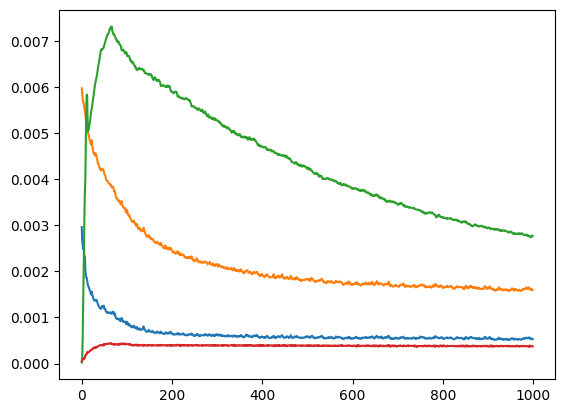

In [ ]:
plt.plot(snapshot['LOSS_HIS'])

In [ ]:
def _run_batch(model,optimizer,source,target):
    loss_funcs, loss_weights= _set_loss_function(model)
    optimizer.zero_grad()
    y_pred = model(source)
    loss = torch.stack([loss_funcs[i](target[i],y_pred[i])*loss_weights[i] for i in range(len(loss_weights))])
    loss.sum().backward()
    optimizer.step( )
    torch.cuda.empty_cache()
    return loss

def _set_loss_function(model):
    image_loss_func = nn.MSELoss()
    # orient_loss_func = nn.CosineSimilarity()
    # pos_loss_func = lambda y_true, y_pred: 1-torch.mean(orient_loss_func(y_true,y_pred))
    # neg_loss_func = lambda _,y_pred: 1-torch.mean(image_loss_func(y_pred, torch.stack([self.model.module.atlas for _ in range(y_pred.shape[0])])))
    pos_loss_func = lambda _,y_pred: image_loss_func(y_pred, torch.stack([model.FA_model.atlas for _ in range(y_pred.shape[0])]))
    neg_loss_func = lambda y_true_dict,y_pred_dict: torch.mean(torch.stack([image_loss_func(y_pred,y_true_dict[key]) for key,y_pred in y_pred_dict.items()]))
    mean_flow_loss = lambda _,y_pred: torch.square(y_pred).mean()
    loss_funcs = [pos_loss_func,neg_loss_func,mean_flow_loss, vxm.losses.Grad('l2', loss_mult=2).loss]
    loss_weights = [0.5, 0.5, 0.1, 0.01]
    return loss_funcs, loss_weights


In [ ]:
dataset = FiberDatasetDir(pathlib.Path('/data01/junyi/datasets/HCP_100'),crop)
# data = next(iter(DataLoader(dataset,batch_size=1,num_workers=8)))

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

def plot_grid(grid, ax=None, **kwargs):
    ax = ax or plt.gca()
    segs1 = grid.transpose(1,2,0)
    segs2 = segs1.transpose(1,0,2)
    ax.add_collection(LineCollection(segs1, **kwargs))
    ax.add_collection(LineCollection(segs2, **kwargs))
    ax.autoscale()
    ax.set_xticks([])
    ax.set_yticks([])
    

In [11]:
flow =nib.load('/data01/junyi/results/tracts_related/flowsnapshot20_16tracts_0.5_whole/whole/SUB000.nii.gz').get_fdata()

torch.Size([2, 128, 160])

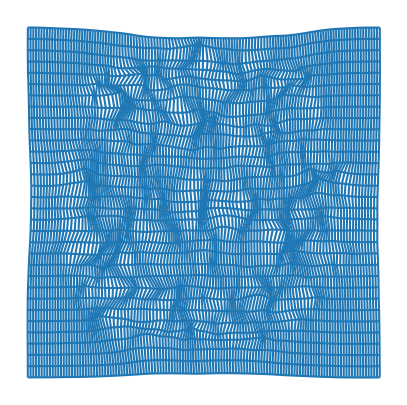

In [53]:
x,y = torch.meshgrid([torch.arange(128),torch.arange(160)],indexing='ij')

fig , axes = plt.subplots(1,1,figsize=(5,5))
axes = [axes]
for i, flows in enumerate([flow]):
    grid_shift = nn.functional.interpolate((torch.from_numpy(flows[...,45,:2]).permute(-1,0,1)+torch.stack([x,y])),scale_factor=(0.2),mode='linear')
    plot_grid(grid_shift.detach().numpy(),axes[i])
    # axes[i].set_title(backbone_tracts[i],size=30)
    if i >=33:
        break
plt.axis('off')
plt.savefig('abc.png')